# 1. Solving the heat equation on GPU

Use ``cupy`` to write a platform-agnostic solver for the heat equation that can run on a GPU.

> **Note:** If you don't have an NVIDIA GPU or CUDA installed on your computer, you will need
> to run this exercise on Google Colab. to activate the ``GPU`` runtime, click on ``Runtime``
> -> ``Change runtime type`` and select ``GPU``.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SEE-MOF/ssdp/blob/main/lectures/13/ssdp_lecture_13_solution.ipynb)

## a) Installing ``cupy``

- Run ``!nvidia-smi`` to determine which version of CUDA is running on your system. It is
  shown in the upper right corner of the output.
- Use the command shown in the table below to install the version of ``cupy`` that corresponds to you CUDA version.
  


<table class="docutils align-center">
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>CUDA</p></th>
<th class="head"><p>Command</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>v9.0</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">!pip</span> <span class="pre">install</span> <span class="pre">cupy-cuda90</span></code></p></td>
</tr>
<tr class="row-odd"><td><p>v9.2</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">!pip</span> <span class="pre">install</span> <span class="pre">cupy-cuda92</span></code></p></td>
</tr>
<tr class="row-even"><td><p>v10.0</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">!pip</span> <span class="pre">install</span> <span class="pre">cupy-cuda100</span></code></p></td>
</tr>
<tr class="row-odd"><td><p>v10.1</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">!pip</span> <span class="pre">install</span> <span class="pre">cupy-cuda101</span></code></p></td>
</tr>
<tr class="row-even"><td><p>v10.2</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">!pip</span> <span class="pre">install</span> <span class="pre">cupy-cuda102</span></code></p></td>
</tr>
<tr class="row-odd"><td><p>v11.0</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">!pip</span> <span class="pre">install</span> <span class="pre">cupy-cuda110</span></code></p></td>
</tr>
</tbody>
</table>

In [ ]:
!nvidia-smi
!pip install cupy-cuda101

## b)

Complete the ``step`` function below so that it performs a step of the heat equation solver. Use again
$0.1$ as time step and $\alpha = 1.0$

In [17]:
%matplotlib inline

import numpy as np
#import cupy as cp
import matplotlib.pyplot as plt

In [18]:
def initial_state(size):
    """
    Return: numpy.ndarray containing the heat distribution at time t = 0.
    """
    u = np.zeros((size, size))
    n = int(0.05 * size)
    u[size // 4 : 3 * size // 4 + 1, size // 2 - n : size // 2 + n + 1] = 1.0
    u[size // 2 - n : size // 2 + n + 1, size // 4 : 3 * size // 4 + 1] = 1.0
    return u


In [19]:
def step(u):
    """
    Perform a solver step of the heat equation.
    
    Args:
        u: n x n numpy.ndarray containing the heat distribution at time t.
        
    Return:
        n x n numpy.ndarray containing the heat distribution at time t + 0.1.
    
    """
    l = u[:-2, 1:-1] + u[2:, 1:-1]
    l += u[1:-1, :-2] + u[1:-1, 2:]
    l -= 4.0 * u[1:-1, 1:-1]

    u_next = u.copy()
    u_next[1:-1, 1:-1] += 0.1 * l

    return u_next

In [20]:
def solve_heat_equation_cpu(size, n_steps):
    u = initial_state(size) 
    for i in range(n_steps):
        u = step(u)
    return u

In [ ]:
def solve_heat_equation_gpu(size, n_steps):
    u = initial_state(size) 
    u_gpu = cp.asarray(u)
    for i in range(n_steps):
        u_gpu = step(u_gpu)
    return u_gpu.get()

In [ ]:
%timeit solve_heat_equation_cpu(1024, 1000)

In [ ]:
%timeit solve_heat_equation_gpu(1024, 1000)

In [ ]:
u_cpu = solve_heat_equation_cpu(1024, 1000)
u_gpu = solve_heat_equation_gpu(1024, 1000)

In [ ]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

f = plt.figure(figsize=(9, 4))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.1])
norm = Normalize(1.0, 0.0)

ax = plt.subplot(gs[0])
img_cpu = ax.imshow(u_cpu)
ax.set_title("(a) CPU", loc="left")

ax = plt.subplot(gs[1])
img = ax.imshow(u_gpu)
ax.set_title("(b) GPU", loc="left")

ax = plt.subplot(gs[2])
plt.colorbar(img, cax=ax, label="$u$")
plt.tight_layout()

## c.) 
Redefine the ``initial_state`` function so that it creates an array with floating point type ``np.float32`` instead the default of ``np.float64``. The repeat the runtime comparison between CPU and GPU. 

In [2]:
def initial_state(size):
    """
    Return: numpy.ndarray containing the heat distribution at time t = 0.
    """
    u = np.zeros((size, size), dtype=np.float32)
    n = int(0.05 * size)
    u[size // 4 : 3 * size // 4 + 1, size // 2 - n : size // 2 + n + 1] = 1.0
    u[size // 2 - n : size // 2 + n + 1, size // 4 : 3 * size // 4 + 1] = 1.0
    return u

In [ ]:
%timeit solve_heat_equation_cpu(1024, 1000)

In [ ]:
%timeit solve_heat_equation_gpu(1024, 1000)

# 2. Solving the heat equation using Fourier transformation

## a.)

Complete the function below that uses Fourier transform to solve the heat equation. Use ``numpy.fft.fft2`` and
``numpy.fft.ifft2`` to perform the Fourier transform an its inverse.

> **Note:** You can use ``numpy.fft.fftfreq``. to calculate the frequencies $\frac{m}{N}$ and $\frac{n}{N}$
    corresponding to each coefficient.

In [12]:
def heat_equation_fft(u0, t):
    N = u0.shape[0]
    A = np.fft.fft2(u0)
    
    n = np.fft.fftfreq(N)
    m, n = np.meshgrid(n, n)
    c = np.exp(- (2.0 * np.pi) ** 2 * (m**2  + n**2) * t)
    
    A_t = c * A
    return np.fft.ifft2(A_t).real

In [13]:
def solve_heat_equation_fft(size, n_steps):
    u = initial_state(size) 
    return heat_equation_fft(u, n_steps * 0.1)

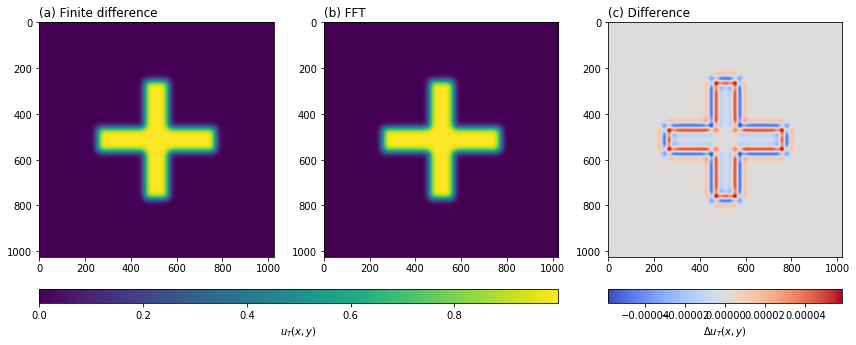

In [22]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

gs = GridSpec(2, 6, height_ratios=[1.0, 0.05])
norm = Normalize(1.0, 0.0)

f = plt.figure(figsize=(12, 5))
ax = plt.subplot(gs[0, :2])
img_cpu = ax.imshow(u_cpu)
ax.set_title("(a) Finite difference", loc="left")

ax = plt.subplot(gs[0, 2:4])
img = ax.imshow(u_fft.real)
ax.set_title("(b) FFT", loc="left")

ax = plt.subplot(gs[0, 4:])
d = u_cpu - u_fft
d_max = np.max(np.abs(d))
error_norm = Normalize(-d_max, d_max)
img_error = ax.imshow(d, cmap="coolwarm", norm=error_norm)
ax.set_title("(c) Difference", loc="left")

ax = plt.subplot(gs[1, :4])
plt.colorbar(img_cpu, cax=ax, label="$u_T(x, y)$", orientation="horizontal")
plt.tight_layout()

ax = plt.subplot(gs[1, 4:])
plt.colorbar(img_error, cax=ax, label="$\Delta u_T(x, y)$", orientation="horizontal")
plt.tight_layout()

## b.)

Write a platform agnostic version of the ``heat_equation_fft`` function which can run on a GPU.
Compare the runtime of the GPU version with the CPU version.

In [ ]:
def heat_equation_fft(u0, t):
    xp = cp.get_array_module(u0)
    N = u0.shape[0]
    A = xp.fft.fft2(u0)
    
    n = xp.arange(N // 2)
    m, n = xp.meshgrid(n, n)
    c = xp.exp(- 4.0 * xp.pi ** 2 * (m**2  + n**2) / N ** 2 * t)
    N2 = N//2
    A_t = xp.copy(A)
    A_t[:N2, :N2] *= c
    A_t[:N2, N2 + 1:] = xp.fliplr(A_t[:N2, 1:N2])
    A_t[N2 + 1:, :] = xp.flipud(A_t[1:N2, :])
    
    return xp.fft.ifft2(A_t).real

In [ ]:
def solve_heat_equation_fft_gpu(size, n_steps):
    u = cp.asarray(initial_state(size))
    return heat_equation_fft(u, n_steps * 0.1)

In [ ]:
%timeit solve_heat_equation_fft_gpu(1024, 1000)

# 3. Getting started with IPython Parallel

## a.)

Install ``ipyparallel`` and start controller and with 4 engines. When both are started correctly the code below should execute without errors.

In [3]:
import ipyparallel as ipp
client = ipp.Client()
view = client.direct_view()

## b.)


In [7]:
def say_hi():
    import time
    time.sleep(2)
    import os
    print(f"Hi from process {os.getpid()}")
results = view.apply(say_hi)

In [8]:
import os
os.getpid()

31908

In [9]:
results.get()
results.display_outputs()

[stdout:0] Hi from process 11013
[stdout:1] Hi from process 11014
[stdout:2] Hi from process 11015
[stdout:3] Hi from process 11018


# 4. Different views

Run the code below and look at the results that it produces. What do the resulting plots display and what causes the different results obtained with different views?

In [10]:
direct_view = client.direct_view()
direct_view.scatter("engine_id", client.ids)

def return_id(dummy_argument):
    import time
    time.sleep(engine_id[0] * 0.01)
    return engine_id[0]

In [ ]:
direct_view = client.direct_view()
load_balanced_view = client.load_balanced_view()

result = direct_view.map(return_id, range(1024))
ids_direct = result.get()
print(f"Direct view finished after {result.wall_time} s.")

In [57]:
result = load_balanced_view.map(return_id, range(1024))
ids_balanaced = result.get()
print(f"Load-balanced view finished after {result.wall_time} s.")

Load-balanced view finished after 11.78599 s.


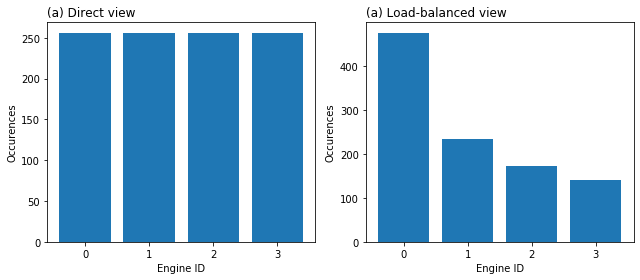

In [56]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

plt.figure(figsize=(9, 4))
bins = np.arange(0, 5) - 0.5
gs = GridSpec(1, 2)
x = np.array([0, 1, 2, 3])

ax = plt.subplot(gs[0, 0])
y, _ = np.histogram(ids_direct, bins=bins)
ax.bar(x, y)
ax.set_title("(a) Direct view", loc="left")
ax.set_xlabel("Engine ID")
ax.set_ylabel("Occurences")

ax = plt.subplot(gs[0, 1])
y, _ = np.histogram(ids_balanced, bins=bins)
ax.bar(x, y)
ax.set_title("(a) Load-balanced view", loc="left")
ax.set_xlabel("Engine ID")
ax.set_ylabel("Occurences")

plt.tight_layout()

# 5. Calculate $\pi$

The value of $\pi$ can be calculated with the following procedure:

1. Sample a random point in a unit cube by calculating pair of random numbers
   $(x, y)$ with $-0.5 \leq x, y \leq 0.5$
2. Calculate the distance of the random point to the origin.
3. Repeat steps 1. and 2. n times and calculate the fraction of times the distance
    is less than 0.5.
4. Multiply the fraction by 4, which will yield an approximate value of $\pi$.


Use ``ipyparallel`` to calculate the value of $\pi$ using Monte Carlo simulation.